### Develop Statistical Arbitrage Strategy using Highly Correlated, Cointegrated Trading Pairs

Now, considering rolling momentum as an additional input when generating signals

In [1]:
from binance_market_module import BinanceMarketModule
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import scipy.stats as st
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
fg = (20, 3)
interval = '1d'
start = '2017-01-01'
end = '2023-03-01'

In [6]:
bmod = BinanceMarketModule('spot')
# check all available datasets for backtesting, and obtain relevant tickers

tickers = ['BTCUSDT', 'ETHUSDT', 'ETCUSDT', 'LTCUSDT', 'AAVEUSDT', 'ADAUSDT', 'BNBUSDT', 'XRPUSDT', 'NEOUSDT']
# tickers = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'AAVEUSDT']
df = pd.DataFrame()
for ticker in tickers:
    # pull data and construct
    try:
        current_df = bmod.retrieveOHLCV(ticker, interval, start, end)
        current_df = current_df.set_index('close_ts')[['close']].rename(columns={'close': ticker})
        df = pd.concat([df, current_df], axis=1)
        print('Ticker Done:', ticker)
    except:
        continue
    
# truncate dataset till all rows have data
df.dropna(how='any', axis=0, inplace=True)

Ticker Done: BTCUSDT
Ticker Done: ETHUSDT
Ticker Done: LTCUSDT
Ticker Done: AAVEUSDT
Ticker Done: ADAUSDT
Ticker Done: BNBUSDT
Ticker Done: XRPUSDT
Ticker Done: NEOUSDT


Set Training and Test Sets

In [16]:
confidence = 0.85  # confidence interval, meaning threshold is anything outside of 
window = int(180)  # in days 180 works
transaction_cost = 0.00

# train on half
midpoint = len(df) // 2
train_df = df[:midpoint]
test_df = df[midpoint-window:]

Use only the training set for investigating potential

In [17]:
# chekc correlation matrix
corr = train_df.pct_change().corr()

In [18]:
corr

,BTCUSDT,ETHUSDT,LTCUSDT,AAVEUSDT,ADAUSDT,BNBUSDT,XRPUSDT,NEOUSDT
BTCUSDT,1.000000,0.703139,0.736433,0.343973,0.488414,0.520791,0.396686,0.573461
ETHUSDT,0.703139,1.000000,0.750441,0.587940,0.580982,0.491858,0.421898,0.626557
LTCUSDT,0.736433,0.750441,1.000000,0.447873,0.528627,0.497533,0.503113,0.667353
AAVEUSDT,0.343973,0.587940,0.447873,1.000000,0.393816,0.300714,0.329291,0.417908
ADAUSDT,0.488414,0.580982,0.528627,0.393816,1.000000,0.422351,0.367389,0.539762
BNBUSDT,0.520791,0.491858,0.497533,0.300714,0.422351,1.000000,0.341881,0.547664
XRPUSDT,0.396686,0.421898,0.503113,0.329291,0.367389,0.341881,1.000000,0.509227
NEOUSDT,0.573461,0.626557,0.667353,0.417908,0.539762,0.547664,0.509227,1.000000


In [19]:
# check cointegration matrix
def cointegration_matrix(data):
    # check no. of columns
    n = data.shape[1]
    cols = list(data.keys())
    cache = {}
    output_df = pd.DataFrame(index=cols, columns=cols)
    
    # iterate through, implementing caching to save time
    for i in range(n):
        for j in range(n):
            if cols[i] == cols[j]:
                output_df.iloc[i, j] = 0
            else:                
                pair = tuple(sorted((cols[i], cols[j])))
                coint_output = coint(data[cols[i]], data[cols[j]])
                if pair not in cache:
                    cache[pair] = coint_output
                    output_df.iloc[i, j] = coint_output[1]
                else:
                    coint_output = cache[pair]
                    output_df.iloc[i, j] = coint_output[1]
                    
            # check ticker
            #print(cols[i], cols[j])
        
    return output_df

In [20]:
coint_df = cointegration_matrix(train_df)

In [21]:
coint_df

,BTCUSDT,ETHUSDT,LTCUSDT,AAVEUSDT,ADAUSDT,BNBUSDT,XRPUSDT,NEOUSDT
BTCUSDT,0,0.625823,0.530258,0.297857,0.661332,0.732062,0.811389,0.693811
ETHUSDT,0.625823,0,0.768525,0.911895,0.411622,0.676944,0.601952,0.380414
LTCUSDT,0.530258,0.768525,0,0.06629,0.080398,0.216903,0.510705,0.240631
AAVEUSDT,0.297857,0.911895,0.06629,0,0.667919,0.628693,0.743756,0.534549
ADAUSDT,0.661332,0.411622,0.080398,0.667919,0,0.504689,0.805107,0.411034
BNBUSDT,0.732062,0.676944,0.216903,0.628693,0.504689,0,0.440147,0.132807
XRPUSDT,0.811389,0.601952,0.510705,0.743756,0.805107,0.440147,0,0.032211
NEOUSDT,0.693811,0.380414,0.240631,0.534549,0.411034,0.132807,0.032211,0


In [423]:
# checking on cointegration
# top picks: AAVE/LTC, AAVE/NEO, XRP/NEO

In [424]:
assets = ['AAVEUSDT', 'LTCUSDT']
ladf = df[assets]

In [427]:
assets[0]

'AAVEUSDT'

In [428]:
# checking on the spread
lacorr = corr[assets[0]][assets[1]]

In [ ]:
df[]

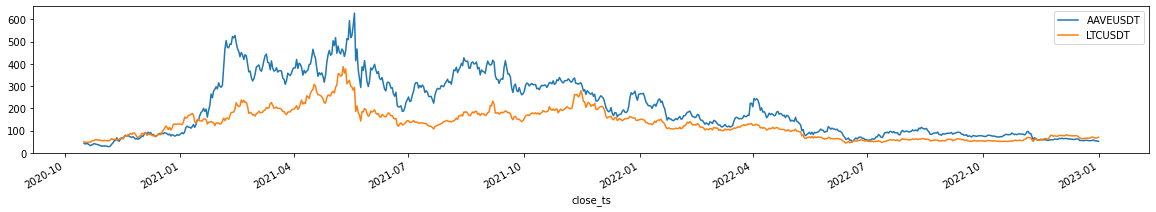

In [435]:
df[[assets[0], assets[1]]].plot(figsize=fg)
plt.show()

In [441]:
# calculating hedging ratio
# Maintain AAVE / LTC
hedge_ratio = lacorr * ladf[assets[0]].std() / ladf[assets[1]].std()

In [446]:
assets[0]

'AAVEUSDT'

In [447]:
# calculating spread
spread = ladf[assets[0]] - ladf[assets[1]] * hedge_ratio

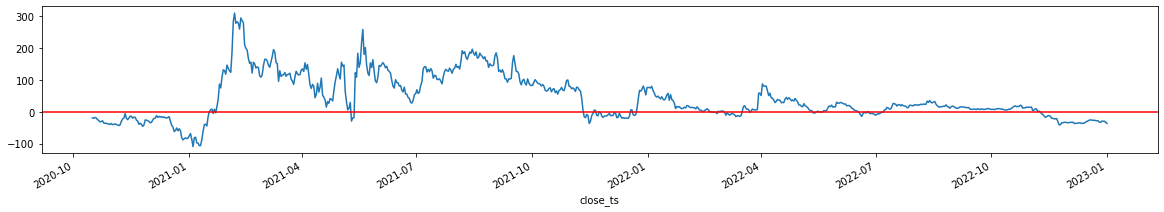

In [448]:
spread.plot(figsize=fg)
plt.axhline(0, color='red')
plt.show()

If the spread is stationary, this means that the signal is mean-reverting.

In [449]:
# checking on stationarity for mean-reversion
adf = adfuller(spread, maxlag=1)

In [450]:
adf

(-2.9992413149093413,
 0.03496531268789229,
 0,
 805,
 {'1%': -3.4384994096285393,
  '5%': -2.8651370452361107,
  '10%': -2.56868539060993},
 6619.992398910936)

In [451]:
adf_p_value = adf[1]

In [452]:
adf_p_value

0.03496531268789229

Since the pvalue is less than the 5% significant level, based on a 1% significance level we can reject the null hypothesis that the spread has a unit root, and can conclude that the spread is stationary, and that mean-reversion can take place.

In [453]:
hedge_ratio

1.2598201214766256

In [454]:
ladf['price_ratio'] = ladf[assets[0]] / ladf[assets[1]]

In [455]:
ladf['adj_price_ratio'] = ladf[assets[0]] / (ladf[assets[1]] * hedge_ratio)

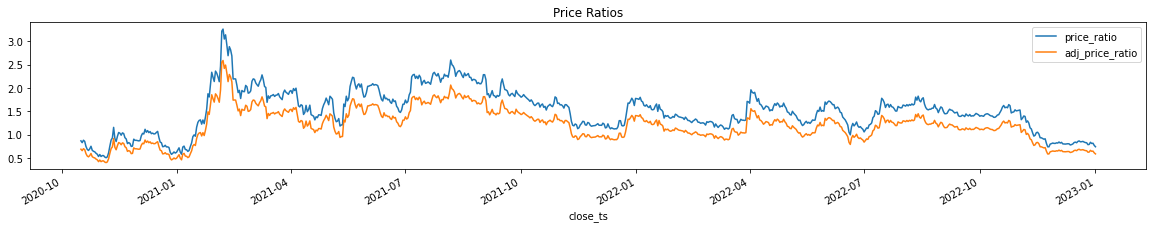

In [456]:
# seems like there will be mean-reversion
ladf[['price_ratio', 'adj_price_ratio']].plot(figsize=fg)
plt.title('Price Ratios')
plt.show()

In [528]:
# create class to generate signal
class StatArb:
    
    # constructor
    def __init__(self, df: pd.DataFrame, interval='day'):
        # initialise variables
        self.df = df
        self.position_state = 0
        self.position_states = []
        self.transactions = 0
        self.transactions_count = []
        self.transaction_happen = 0
        self.transaction_happen_records = []
        self.transaction_cost = []
        self.transaction_cost_param = 0
        self.annual_factor = 365
        
        # determine interval
        if interval == 'day':
            self.annual_factor = 365
        elif interval == 'hour':
            self.annual_factor = 365 * 24
        else:
            self.annual_factor = 365
            
        # check for required number of assets
        if df.shape[1] == 2:
            data = df.copy()
            # generate relevant figures for statistical arbitrage
            assets = list(data.columns)
            rename = {k: v for k, v in zip(assets, ['x', 'y'])}
            data.rename(columns = rename, inplace=True)
            for symbol in list(data.columns):
                data['norm_' + symbol] = data[symbol] / data[symbol][0]
                data['pct_change_' + symbol] = data[symbol].pct_change()
                
            # generate price ratio x/y
            symbols = list(data.columns)
            
            # ratio = x / y
            # if ratio is high, this means we want to short X, and long Y
            # if ratio is low, we want to long X and short Y
            data['ratio'] = data['norm_' + symbols[0]] / data['norm_' + symbols[1]]
            self.data = data
            self.symbols = data
        else:
            print('Module requires only 2 assets')
            
    # reset class
    def reset(self):
        self.__init__(self.df)
        self.p_data = None
        
    # generate signal based on rolling window, mean reversion
    def generate_signal(self, window: int, confidence_level: float):
        self.window = window
        self.confidence_level = confidence_level
        
        # process data, respecting the window
        self.p_data = self.data.copy()
        self.p_data['ratio_mean'] = self.p_data['ratio'].rolling(self.window).mean()
        self.p_data['ratio_std'] = self.p_data['ratio'].rolling(self.window).std()
        self.p_data = self.p_data[window:]
        
        # generate signal using internal static function; and apply
        self.p_data['signal_strength'] = self.p_data.apply(lambda row: StatArb.signal_strength(row['ratio'],
                                                                                       row['ratio_mean'],
                                                                                       row['ratio_std'],
                                                                                       self.confidence_level), axis=1)
        return self.p_data
    
    # based on signal strength, obtain positions
    def generate_positions(self, transaction_cost: float = 0):
        # iterate through processed data, and generate positions
        # position state = 1 --> short X, long Y
        # position state = -1 --> long X, short Y
        
        self.transaction_cost = transaction_cost
        
        for i in range(len(self.p_data)):

            # extract data from a row
            values = self.p_data.iloc[i, :]
            signal_strength = values['signal_strength']
            ratio_mean = values['ratio_mean']
            ratio = values['ratio']
            self.transaction_happen = 0

            # if there is no current position, check for signal strength
            if self.position_state == 0:
                if signal_strength > 0:
                    self.position_state = 1
                    self.transactions += 1
                    self.transaction_happen = 1
                elif signal_strength < 0:
                    self.position_state = -1
                    self.transactions += 1
                    self.transaction_happen = 1
                else:
                    self.position_state = 0
                    
            # if a position already exists, check whether we can close it
            elif self.position_state == 1:

                # if ratio has fallen below the mean, we can close the position
                if ratio < ratio_mean:
                    self.position_state = 0 # close position
                    self.transactions += 1
                    self.transaction_happen = 1
                # otherwise, maintain the position
                else:
                    self.position_state = 1 # maintain position
                    self.transaction_happen = 0                    

            # if a position already exists, check whether we can close it
            elif self.position_state == -1:
                if ratio > ratio_mean:
                    self.position_state = 0 # close position
                    self.transactions += 1
                    self.transaction_happen = 1
                else:
                    self.position_state = -1 # maintain position
                    self.transaction_happen = 0
            else:
                print('Position State should only be 1 or -1')

            # store position states and transaction costs
            self.position_states.append(self.position_state)
            self.transactions_count.append(self.transactions)
            self.transaction_happen_records.append(self.transaction_happen)
        
        # append to processed data
        period_shift = 1
        self.p_data['position_state'] = self.position_states
        self.p_data['adj_position_state'] = self.p_data['position_state'].shift(periods=period_shift) # should shift by 1
        self.p_data['transaction_cost'] = self.transaction_happen_records
        self.p_data['transaction_cost'] = self.p_data['transaction_cost'].apply(lambda x: x * self.transaction_cost)
        self.p_data['adj_transaction_cost'] = self.p_data['transaction_cost'].shift(periods=period_shift) # should shift by 1
        self.p_data['cumulative_transactions'] = self.transactions_count
        
        # compute period returns
        # position state = 1 --> short X, long Y: 
        # position state = -1 --> long X, short Y
        # deduct transaction costs
        self.p_data['period_return'] = - (self.p_data['adj_position_state'] * self.p_data['pct_change_x']) \
                                       + (self.p_data['adj_position_state'] * self.p_data['pct_change_y']) \
                                       - self.p_data['adj_transaction_cost']
        
        # compute cumulative returns
        self.p_data['cum_return'] = (self.p_data['period_return'] + 1).cumprod() - 1
        
    # obtain net position
    def generate_net_portfolio(self):
        # positive if overall long, negative if overall short        
        net_portfolio = 0
        long_portfolio = 1
        short_portfolio = 1
        all_net_portfolio = []
        for i in range(len(self.p_data)):
            values = self.p_data.iloc[i, :]
            position_state = values['adj_position_state']
            if position_state == 0:
                net_portfolio = 0  # all cash, no position taken
                # reset long and short portfolios
                long_portfolio = 1
                short_portfolio = 1
                
                # position_state = 1: short X, long Y
                # position_state = -1: short Y, long X
                # net position is out of entire position
                # store long and shoort
            elif position_state == 1:
                long_portfolio = (long_portfolio) * (1 + values['pct_change_y'])
                short_portfolio = (short_portfolio) * (1 + values['pct_change_x'])
                net_portfolio = (long_portfolio - short_portfolio) / (abs(long_portfolio) + abs(short_portfolio))
            else:
                long_portfolio = (long_portfolio) * (1 + values['pct_change_x'])
                short_portfolio = (short_portfolio) * (1 + values['pct_change_y'])
                net_portfolio = (long_portfolio - short_portfolio) / (abs(long_portfolio) + abs(short_portfolio))
                            
            # store net position
            all_net_portfolio.append(net_portfolio)

        # update net position
        self.p_data['net_portfolio'] = all_net_portfolio
        
    # plot performance   
    def plot_all(self, fg: tuple = (20, 3)):
        z_score = StatArb.get_z_score(self.confidence_level)
        d = self.p_data.copy()
        
        plt.figure(figsize=fg)
        plt.plot(d['ratio'])
        plt.plot(d['ratio_mean'])
        plt.fill_between(d.index, d['ratio_mean'] - z_score * d['ratio_std'], d['ratio_mean'] + z_score * d['ratio_std'], color='lightblue')
        plt.title('Ratio Time Series, with Confidence Interval')

        plt.figure(figsize=fg)
        plt.plot(d['norm_x'])
        plt.plot(d['norm_y'])
        plt.title('Normalised X and Y')

        plt.figure(figsize=fg)
        plt.plot(d[['cum_return']])
        plt.title('Cumulative Returns')

        plt.figure(figsize=fg)
        plt.plot(d['period_return'])
        plt.title('Period Returns')

        plt.figure(figsize=fg)
        plt.plot(d['signal_strength'])
        plt.title('Signal Strength')

        plt.figure(figsize=fg)
        plt.plot(d[['position_state']])
        plt.title('Position States')

        plt.figure(figsize=fg)
        plt.plot(d['cumulative_transactions'])
        plt.title('Cumulative Transactions')

        plt.figure(figsize=fg)
        plt.plot(d['net_portfolio'])
        plt.title('Net Portfolio Position')
        plt.show()
        
    # generate results summary
    def results(self):
        # generate results for portfolio, as well as individual assets
        
        sharpe = np.mean(self.p_data['period_return']) / np.std(self.p_data['period_return']) * np.sqrt(self.annual_factor)
        sortino = np.mean(self.p_data['period_return']) / np.std(self.p_data[self.p_data['period_return'] < 0]['period_return']) * np.sqrt(self.annual_factor)
        max_drawdown = StatArb.max_drawdown(self.p_data.dropna()['cum_return'] + 1)
        annualised_return = self.p_data['period_return'].mean() * np.sqrt(self.annual_factor)
        cumulative_return = self.p_data['cum_return'].values[-1]
        
        # constructing output from constituent assets
        sharpe_x = np.mean(self.p_data['pct_change_x']) / np.std(self.p_data['pct_change_x']) * np.sqrt(self.annual_factor)
        sortino_x = np.mean(self.p_data['pct_change_x']) / np.std(self.p_data[self.p_data['pct_change_x'] < 0]['pct_change_x']) * np.sqrt(self.annual_factor)
        max_drawdown_x = StatArb.max_drawdown(self.p_data.dropna()['norm_x'] + 1)
        annualised_return_x = self.p_data['pct_change_x'].mean() * np.sqrt(self.annual_factor)
        cumulative_return_x = (self.p_data['x'][-1] - self.p_data['x'][0]) / self.p_data['x'][0]
        
        sharpe_y = np.mean(self.p_data['pct_change_y']) / np.std(self.p_data['pct_change_y']) * np.sqrt(self.annual_factor)
        sortino_y = np.mean(self.p_data['pct_change_y']) / np.std(self.p_data[self.p_data['pct_change_y'] < 0]['pct_change_y']) * np.sqrt(self.annual_factor)
        max_drawdown_y = StatArb.max_drawdown(self.p_data.dropna()['norm_y'] + 1)        
        annualised_return_y = self.p_data['pct_change_y'].mean() * np.sqrt(self.annual_factor)
        cumulative_return_y = (self.p_data['y'][-1] - self.p_data['y'][0]) / self.p_data['y'][0]
        
        # constructing output from portfolio
        # dic['confidence_level'] = self.confidence_level
        # dic['window'] = int(self.window)
        # dic['transaction_cost'] = self.transaction_cost
        output = pd.DataFrame(index=['Sharpe', 'Sortino', 'Max Drawdown', 'Annualised Return', 'Cumulative Return'])
        
        # from portfolio
        output['Portfolio'] = [sharpe, sortino, max_drawdown, annualised_return, cumulative_return]
        output['Asset X'] = [sharpe_x, sortino_x, max_drawdown_x, annualised_return_x, cumulative_return_x]
        output['Asset Y'] = [sharpe_y, sortino_y, max_drawdown_y, annualised_return_y, cumulative_return_y]
        
        return output
        
        
    # generate z_score
    @staticmethod
    def get_z_score(confidence_level: float):
        confidence_input = 1 - (1-confidence_level)/2     # bounding to 0.999
        z_score = st.norm.ppf(confidence_input)
        return z_score
        
    # generate buy and sell signal using mean and std
    @staticmethod
    def signal_strength(ratio, ratio_mean, ratio_std, confidence_level):
        z_score = StatArb.get_z_score(confidence_level)

        # generate lower and upper bounds
        lower_bound = ratio_mean - (z_score * ratio_std)
        upper_bound = ratio_mean + (z_score * ratio_std)

        # generate signal based on lower and upper bound
        if ratio > upper_bound:
            signal_strength = (ratio - upper_bound) / upper_bound
        elif ratio < lower_bound:
            signal_strength = (ratio - lower_bound) / lower_bound
        else:
            signal_strength = 0
        return signal_strength
    
    
    @staticmethod
    def max_drawdown(prices):
        # solving using dynamic programming, where we can achieve linear time complexity
        # initiatise max drawdown and running peak
        all_max_drawdowns = []
        all_drawdowns = []
        max_drawdown = 0
        running_peak = 0

        for price in prices:
            # obtain new peak
            running_peak = max(running_peak, price)

            # obtain new drawdown and calculate new max drawdown
            drawdown = (running_peak - price) / running_peak
            max_drawdown = max(max_drawdown, drawdown)
            all_max_drawdowns.append(max_drawdown)
            all_drawdowns.append(drawdown)

        return max_drawdown

    
    def plot_ratio(self):
        if self.data:
            self.data[['ratio']].plot(figsize=(20, 5))
            plt.title('Price Ratio')
            plt.ylabel('Normalised X / Normalised Y')
            plt.show()
            

In [529]:
ladf.head()

,AAVEUSDT,LTCUSDT,price_ratio,adj_price_ratio
close_ts,,,,
2020-10-16 07:59:59.999,42.999,49.53,0.868141,0.689099
2020-10-17 07:59:59.999,39.461,47.60,0.829013,0.658040
2020-10-18 07:59:59.999,41.365,46.93,0.881419,0.699639
2020-10-19 07:59:59.999,40.750,47.54,0.857173,0.680393
2020-10-20 07:59:59.999,35.980,47.99,0.749740,0.595116


In [553]:
confidence = 0.85  # confidence interval, meaning threshold is anything outside of 
window = int(180)  # in days 180 works
transaction_cost = 0.00

# train on half
midpoint = len(ladf) // 2
train_ladf = ladf[:midpoint]
test_ladf = ladf[midpoint-window:]

Identify optimal parameters for strategy

In [554]:
# initialise mod
mod = StatArb(train_ladf[[assets[0], assets[1]]], interval='day')

# train
print(f'Confidence Level: {confidence}')
print(f'Rolling Window: {window}')
print(f'Transaction Cost %: {transaction_cost}')
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
mod.results()

Confidence Level: 0.85
Rolling Window: 180
Transaction Cost %: 0.0


,Portfolio,Asset X,Asset Y
Sharpe,0.440073,0.225891,0.313439
Sortino,0.329327,0.329276,0.402360
Max Drawdown,0.403855,0.657820,0.641415
Annualised Return,0.010303,0.016486,0.020164
Cumulative Return,0.060954,-0.384388,-0.250161


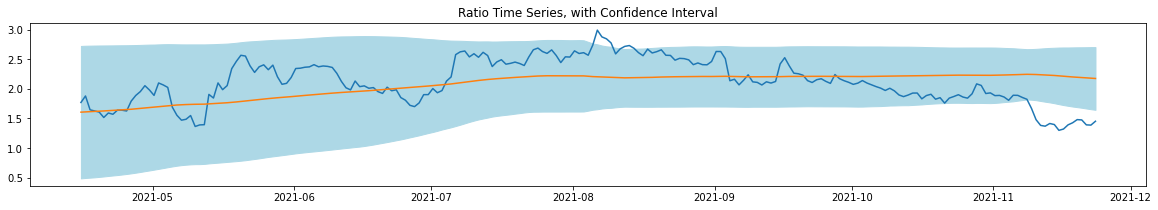

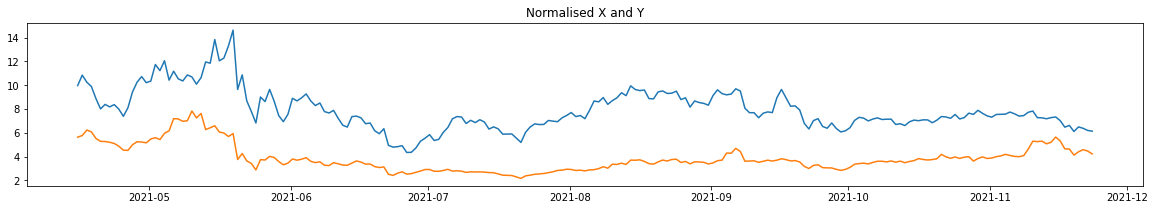

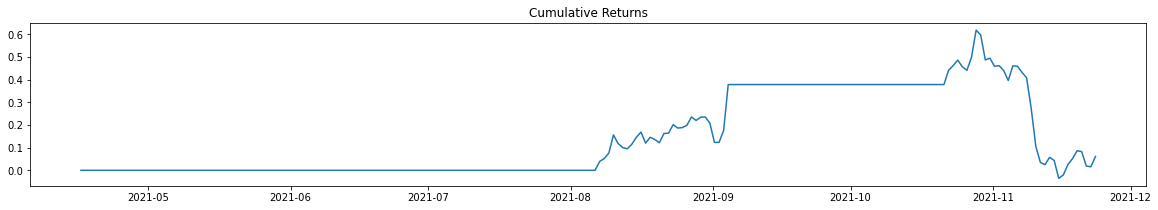

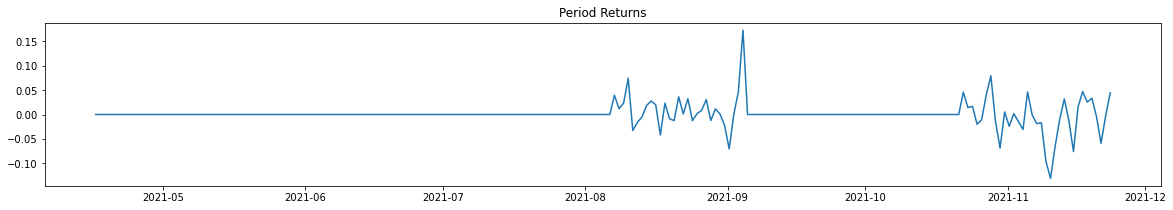

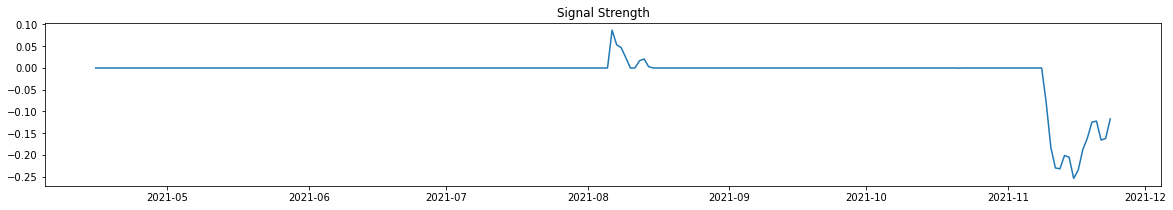

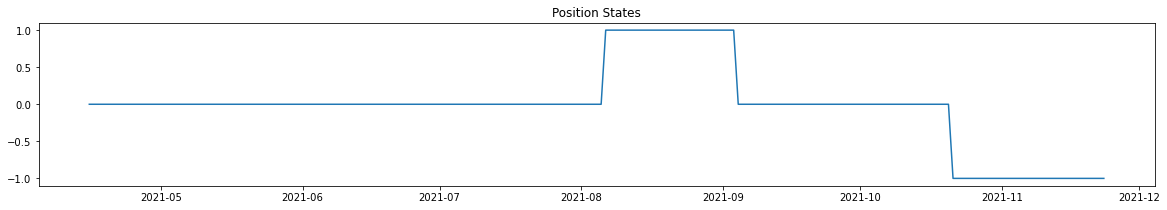

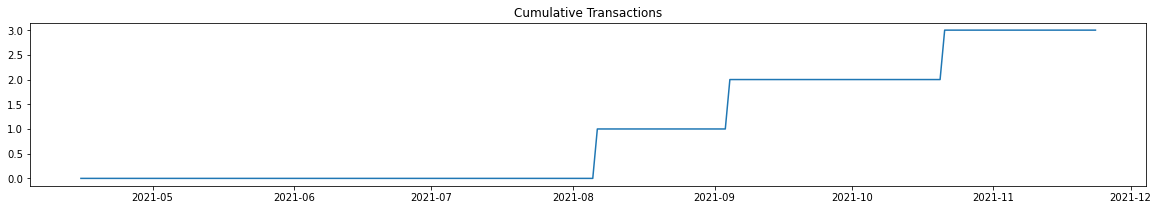

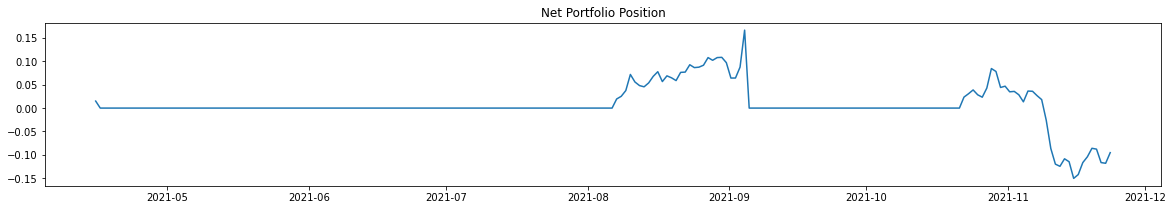

In [555]:
mod.plot_all()
plt.show()

Implement strategy on test set

In [556]:
# initialise mod
mod = StatArb(test_ladf[[assets[0], assets[1]]], interval='day')

# execute on test set
print(f'Confidence Level: {confidence}')
print(f'Rolling Window: {window}')
print(f'Transaction Cost %: {transaction_cost}')
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
mod.results()

Confidence Level: 0.85
Rolling Window: 180
Transaction Cost %: 0.0


,Portfolio,Asset X,Asset Y
Sharpe,1.707621,-0.584904,-0.687374
Sortino,1.958341,-0.919888,-0.962529
Max Drawdown,0.397817,0.350939,0.429989
Annualised Return,0.050868,-0.037592,-0.031469
Cumulative Return,1.442459,-0.807265,-0.675578


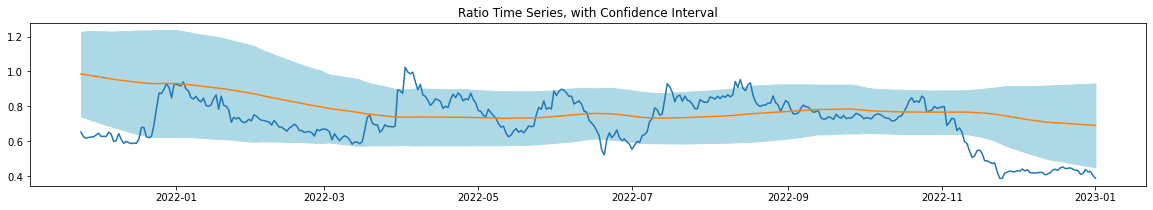

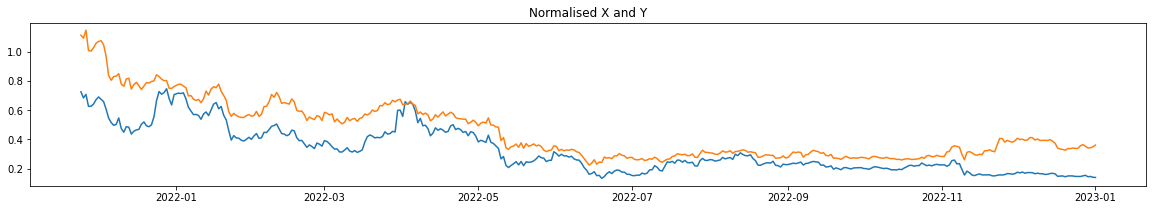

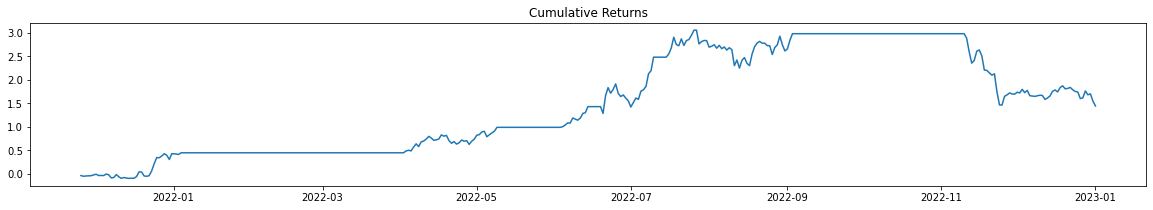

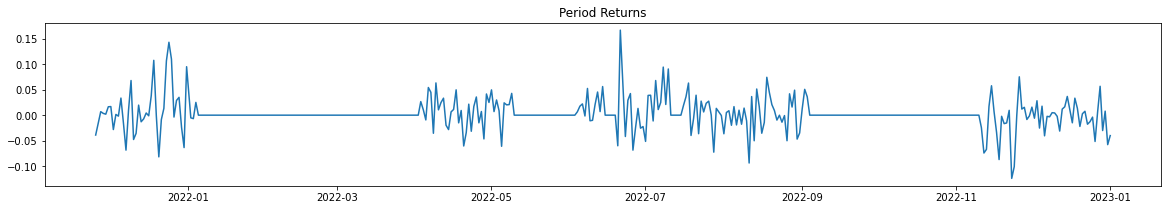

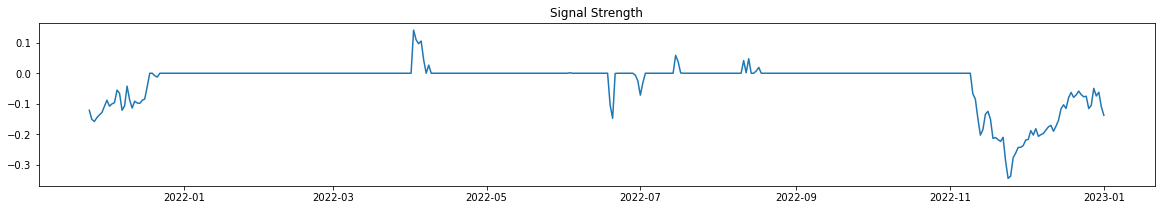

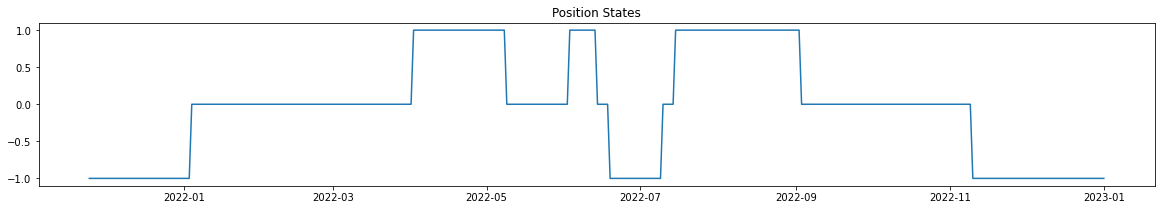

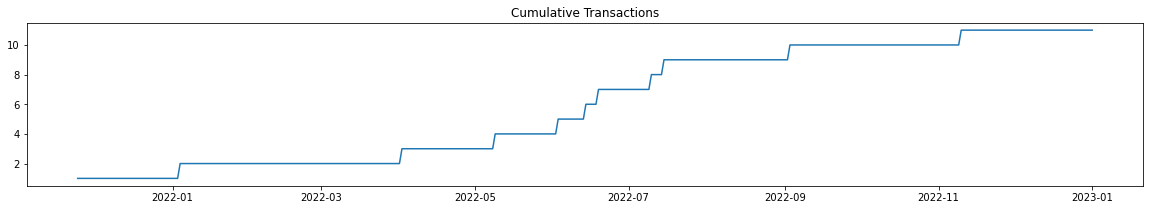

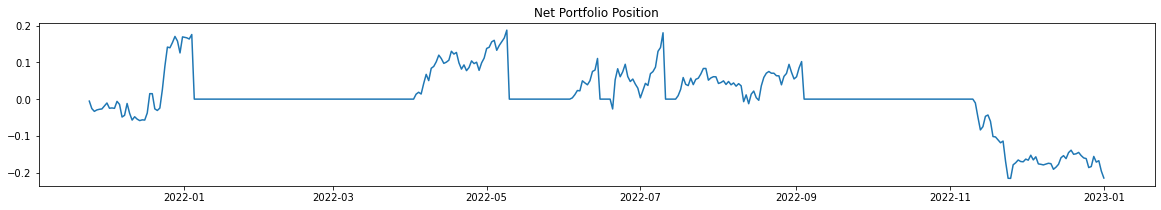

In [557]:
mod.plot_all()
plt.show()

In [542]:
# checking on overall dataset

# initialise mod
mod = StatArb(ladf[[assets[0], assets[1]]], interval='day')

# execute on test set
print(f'Confidence Level: {confidence}')
print(f'Rolling Window: {window}')
print(f'Transaction Cost %: {transaction_cost}')
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
mod.results()

Confidence Level: 0.5
Rolling Window: 210
Transaction Cost %: 0.0


,Portfolio,Asset X,Asset Y
Sharpe,0.820264,-0.444531,-0.410986
Sortino,1.095711,-0.665346,-0.541339
Max Drawdown,0.488742,0.862152,0.734071
Annualised Return,0.032013,-0.029802,-0.021488
Cumulative Return,0.733215,-0.912573,-0.784998


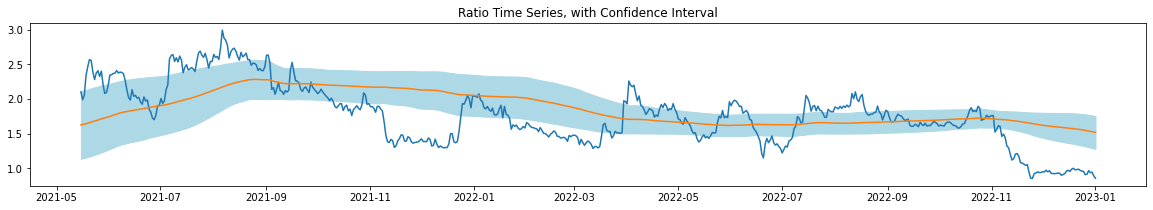

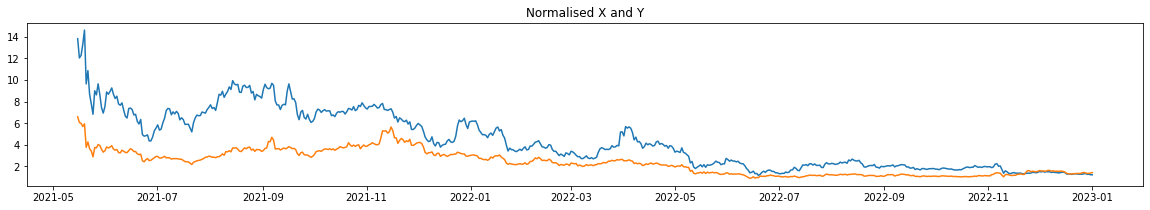

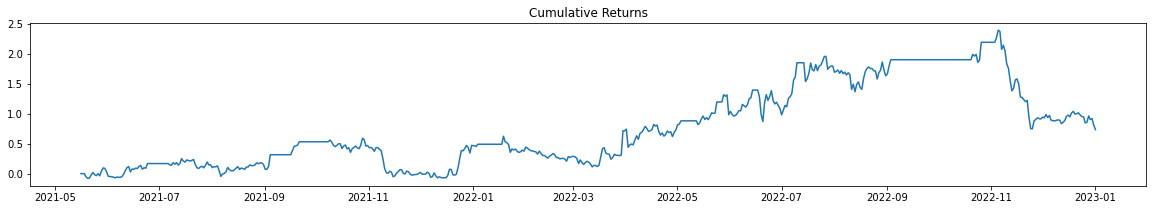

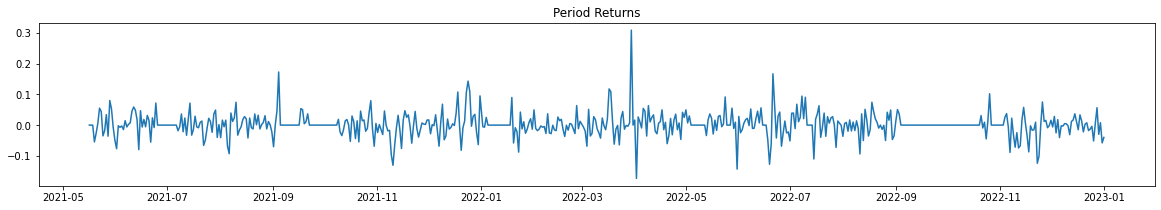

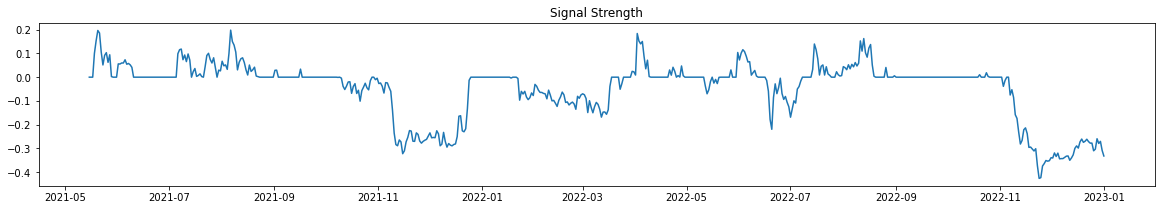

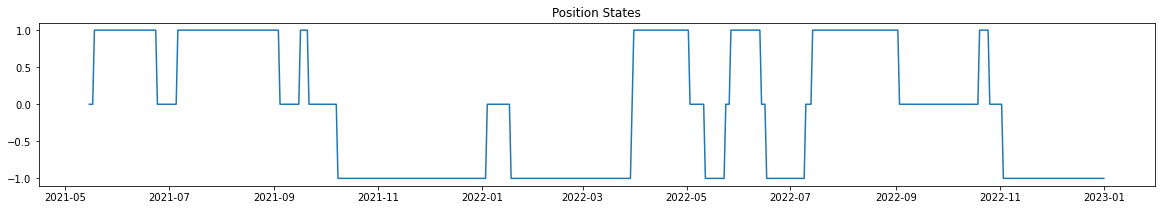

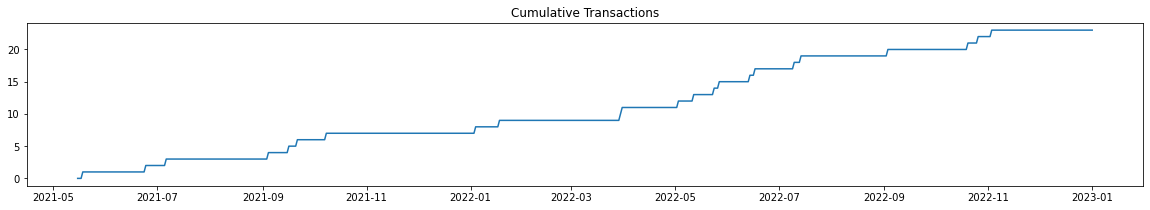

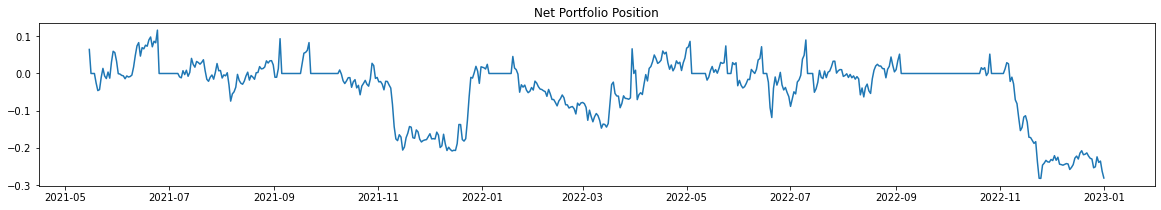

In [543]:
mod.plot_all()
plt.show()

In [561]:
mod.p_data

,x,y,norm_x,pct_change_x,norm_y,pct_change_y,ratio,ratio_mean,ratio_std,signal_strength,position_state,adj_position_state,transaction_cost,adj_transaction_cost,cumulative_transactions,period_return,cum_return,net_portfolio
close_ts,,,,,,,,,,,,,,,,,,
2021-11-24 07:59:59.999,269.8,216.20,0.725464,0.022745,1.112598,0.033955,0.652045,0.984839,0.168689,-0.121240,-1,NaN,0.0,NaN,1,NaN,NaN,-0.005451
2021-11-25 07:59:59.999,254.3,212.20,0.683786,-0.057450,1.092013,-0.018501,0.626170,0.983083,0.170767,-0.150677,-1,-1.0,0.0,0.0,1,-0.038949,-0.038949,-0.025691
2021-11-26 07:59:59.999,263.1,222.90,0.707448,0.034605,1.147077,0.050424,0.616740,0.981234,0.172920,-0.157816,-1,-1.0,0.0,0.0,1,-0.015819,-0.054152,-0.033272
2021-11-27 07:59:59.999,232.8,195.70,0.625975,-0.115165,1.007102,-0.122028,0.621561,0.979165,0.174983,-0.145353,-1,-1.0,0.0,0.0,1,0.006862,-0.047661,-0.029382
2021-11-28 07:59:59.999,232.9,195.10,0.626244,0.000430,1.004014,-0.003066,0.623740,0.976724,0.176860,-0.136249,-1,-1.0,0.0,0.0,1,0.003495,-0.044332,-0.027634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27 23:59:59.999,57.5,68.67,0.154611,0.026786,0.353386,-0.029811,0.437514,0.694457,0.162702,-0.049383,-1,-1.0,0.0,0.0,11,0.056596,1.762252,-0.155802
2022-12-28 23:59:59.999,53.8,66.32,0.144663,-0.064348,0.341293,-0.034222,0.423866,0.693613,0.163711,-0.074418,-1,-1.0,0.0,0.0,11,-0.030126,1.679036,-0.171223
2022-12-29 23:59:59.999,54.5,66.66,0.146545,0.013011,0.343042,0.005127,0.427191,0.692661,0.164762,-0.062111,-1,-1.0,0.0,0.0,11,0.007884,1.700159,-0.167428


In [ ]:
dir(mod)

In [ ]:
conf = [round(x * 0.01, 2) for x in range(1, 100, 1)]
windows = [int(x) for x in range(7, 100, 7)]

In [ ]:
# iterate along and understand the field
transaction_cost = 0.00001 # assume very low transaction costs
overall_results = {} # dictionary to store dataframe
# implement for loops
for w in windows:
    results = pd.DataFrame()  # initialise dataframe for storage    
    for c in conf:
        mod = StatArb(df)
        mod.generate_signal(w, c)
        mod.generate_positions(transaction_cost)
        mod.generate_net_portfolio()
        current_result = mod.results().rename(columns={'value': 'c: ' + str(c)})
        results = pd.concat([results, current_result], axis=1)

    # round results
    results = round(results, 3)
    results = results.transpose()[['confidence_level', 'sharpe']]
    overall_results['w: ' + str(w)] = results
    print(len(results))

In [ ]:
overall_results['w: 14'].transpose()[['confidence_level', 'sharpe']]

In [ ]:
# constructing a list
dic = {}
for k, v in overall_results.items():
    dic[k] = v.values.flatten()

In [ ]:
overall_results['w: 14'].reset_index().plot()

In [ ]:
output = pd.DataFrame()
for k, v in overall_results.items():
    print(len(v))
    

In [ ]:
# convert dict into large dataframe
pd.DataFrame([overall_results])

In [ ]:
display_results = results.transpose()[['confidence_level', 'sharpe']].set_index('confidence_level')

In [ ]:
display_results.plot(figsize=fg)
plt.show()

Optimal cases appear to be in the confidence level ~0.7 to ~0.8 region, for a 30-day case

In [ ]:
display_results.rename(columns={'sharpe': 'n'})

In [ ]:
confidence = 0.95
window = 14
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(0.001)
mod.generate_net_portfolio()
mod.results()

In [ ]:
mod.plot_all()